### Scatterplot of matchups of VIIRS and OLCI S3A/B with aeronet-OC
This notebook demonstrates methodology for cataloging satellite matchups with Aeronet-OC data

In [6]:
# First, import libraries
import earthaccess
import os
from osgeo import gdal
import numpy as np
import math
import rasterio as rio
import xarray as xr
import holoviews as hv
import hvplot.xarray
import datetime
import netCDF4 as nc
import pandas as pd

#### A. Establish methods

In [7]:
earthaccess.login()

In [8]:
#methods part 1
def makeDataset(file,satellite):
    if satellite == 'VIIRS_SNPP': bands = [410, 443, 486, 551, 671] #VIIRS SUOMI NPP
    if satellite == 'Sentinel-3_OLCI/S3A' or satellite == 'Sentinel-3_OLCI/S3B': bands = [400,412,443,490,510,560,620,665,674,681,709] #S3A
    if satellite == 'MODISA_L2_OC' or satellite == 'jbclark_MODISA_250m_HT' or satellite == 'MODIST_L2_OC': bands = [412, 443, 488, 555, 667] #MODIS Ob.DAAC (1.2km)
    print(file)
    modis_ds_raw = xr.open_dataset(file)  
    modis_ds_nav = xr.open_dataset(file, group='navigation_data')
    modis_ds_geo = xr.open_dataset(file, group='geophysical_data')
    if satellite == 'VIIRS_SNPP' or satellite == 'MODISA_L2_OC': 
        modis_ds = xr.Dataset(
                    data_vars={
                    f'Rrs_{bands[0]}':(['x', 'y'], modis_ds_geo[f'Rrs_{bands[0]}'].data),
                    f'Rrs_{bands[1]}':(["x", "y"], modis_ds_geo[f'Rrs_{bands[1]}'].data),
                    f'Rrs_{bands[2]}':(["x", "y"], modis_ds_geo[f'Rrs_{bands[2]}'].data),
                    f'Rrs_{bands[3]}':(["x", "y"], modis_ds_geo[f'Rrs_{bands[3]}'].data),
                    f'Rrs_{bands[4]}':(["x", "y"], modis_ds_geo[f'Rrs_{bands[4]}'].data),
                    f'l2_flags':(["x", "y"], modis_ds_geo[f'l2_flags'].data),
                    'longitude':(["x", "y"], modis_ds_nav['longitude'].data),
                    'latitude':(["x", "y"], modis_ds_nav['latitude'].data)},
                    attrs=dict(isodate=modis_ds_raw.time_coverage_start),)
    elif satellite == 'Sentinel-3_OLCI/S3A' or satellite == 'Sentinel-3_OLCI/S3B':
        modis_ds = xr.Dataset(
                    data_vars={
                    f'Rrs_{bands[0]}':(['x', 'y'], modis_ds_geo[f'Rrs_{bands[0]}'].data),
                    f'Rrs_{bands[1]}':(["x", "y"], modis_ds_geo[f'Rrs_{bands[1]}'].data),
                    f'Rrs_{bands[2]}':(["x", "y"], modis_ds_geo[f'Rrs_{bands[2]}'].data),
                    f'Rrs_{bands[3]}':(["x", "y"], modis_ds_geo[f'Rrs_{bands[3]}'].data),
                    f'Rrs_{bands[4]}':(["x", "y"], modis_ds_geo[f'Rrs_{bands[4]}'].data),
                    f'Rrs_{bands[5]}':(['x', 'y'], modis_ds_geo[f'Rrs_{bands[5]}'].data),
                    f'Rrs_{bands[6]}':(["x", "y"], modis_ds_geo[f'Rrs_{bands[6]}'].data),
                    f'Rrs_{bands[7]}':(["x", "y"], modis_ds_geo[f'Rrs_{bands[7]}'].data),
                    f'Rrs_{bands[8]}':(["x", "y"], modis_ds_geo[f'Rrs_{bands[8]}'].data),
                    f'Rrs_{bands[9]}':(["x", "y"], modis_ds_geo[f'Rrs_{bands[9]}'].data),
                    f'Rrs_{bands[10]}':(["x", "y"], modis_ds_geo[f'Rrs_{bands[10]}'].data),
                    f'l2_flags':(["x", "y"], modis_ds_geo[f'l2_flags'].data),
                    'longitude':(["x", "y"], modis_ds_nav['longitude'].data),
                    'latitude':(["x", "y"], modis_ds_nav['latitude'].data)},
                    attrs=dict(isodate=modis_ds_raw.time_coverage_start),)
    
    return modis_ds

def matchData():
    #Make empty dataframe
    dfScatter = pd.DataFrame(columns = [list(ds.keys())[:-2]])
    dfScatter['fn'] = ''

    #Get nearest pixel
    abslat = np.abs(ds.latitude-aer_lat)
    abslon = np.abs(ds.longitude-aer_lon)
    c = np.maximum(abslon, abslat)
    a = np.where(c == np.min(c))
    index = 0

    #Logic if two pixels are equidistant - use the first one found
    try: 
        if bool(a[1][1]): xloc, yloc = a[0][0],a[1][0]
    except:([xloc], [yloc]) = np.where(c == np.min(c))

    #Crop ds to the selected point
    point_ds = ds.sel(x=xloc, y=yloc)

    #Check if empty
    if (str(point_ds['Rrs_411'].data) == 'nan'):
        print('DS is empty at 411nm')
        pass;
    else:
        #If not empty, append the values to the dataframe
        dfScatter.loc[str(index)]=([point_ds[keys[0]].values, point_ds[keys[1]].values, point_ds[keys[2]].values, 
                                    point_ds[keys[3]].values, point_ds[keys[4]].values, files[n]])
    return(dfScatter)
def convert_flag(flag_value):
    #Flag info from OBDAAC
    flag_masks = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072,
                  262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216, 33554432, 67108864, 134217728,
                  268435456, 536870912, 1073741824, -2147483648]
    flag_meanings = ["ATMFAIL", "LAND", "PRODWARN", "HIGLINT", "HILT", "HISATZEN", "COASTZ", "SPARE", "STRAYLIGHT",
                     "CLDICE", "COCCOLITH", "TURBIDW", "HISOLZEN", "SPARE", "LOWLW", "CHLFAIL", "NAVWARN", "ABSAER",
                     "SPARE", "MAXAERITER", "MODGLINT", "CHLWARN", "ATMWARN", "SPARE", "SEAICE", "NAVFAIL", "FILTER",
                     "SPARE", "BOWTIEDEL", "HIPOL", "PRODFAIL", "SPARE"][::-1]

    # convert the flag value to binary
    binary_flag = bin(int(flag_value) & 0xFFFFFFFFFFFFFFFF)[2:]
    print(f'binary flag: {binary_flag}')
    binary_string = binary_flag.zfill(len(flag_masks))
    print(f'padded string: {binary_string}')
    df = pd.DataFrame({'digit': list(binary_string), 'flag': flag_meanings})
    # OMITTED FLAGS---
    filtered_rows = df[(df['flag'] == 'STRAYLIGHT') | (df['flag'] == 'CLDICE') | #default flags
                           (df['flag'] == 'LAND') | (df['flag'] == 'HILT') | 
                           (df['flag'] == 'HISOLZEN') | (df['flag'] == 'HISATZEN') # optional flags
                           |(df['flag'] == 'HIGLINT') | (df['flag'] ==  'MODGLINT')
                            |(df['flag'] == 'ATMFAIL') 
                      ]
    default_rows = df[(df['flag'] == 'STRAYLIGHT') | (df['flag'] == 'CLDICE') | #default flags
                           (df['flag'] == 'LAND') | (df['flag'] == 'HILT')]
    print(filtered_rows)
    # Check if there is at least one row with a value of 1
    result = any(filtered_rows['digit'] == '1') #any optional?
    default_result = any(default_rows['digit'] == '1') #any default?
    if default_result == True: print(f'default row is flagged')
    if (result == True):
        if default_result == False: print('optional row is flagged')
    return (result) #return boolean
def convert_flag_WINDOW(dataset): #for OLCI, flag out bad flags and return a list of them
    flagValues = (dataset.l2_flags.data)
    qVals = list(np.unique(dataset.l2_flags.data))
    qVals = [x for x in qVals if not np.isnan(x)]
    qVals = [int(x) for x in qVals]
    goodQuality = []
    badQuality = []
    
    flag_masks = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072,
                  262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216, 33554432, 67108864, 134217728,
                  268435456, 536870912, 1073741824, -2147483648]
    flag_meanings = ["ATMFAIL", "LAND", "PRODWARN", "HIGLINT", "HILT", "HISATZEN", "COASTZ", "SPARE", "STRAYLIGHT",
                     "CLDICE", "COCCOLITH", "TURBIDW", "HISOLZEN", "SPARE", "LOWLW", "CHLFAIL", "NAVWARN", "ABSAER",
                     "SPARE", "MAXAERITER", "MODGLINT", "CHLWARN", "ATMWARN", "SPARE", "SEAICE", "NAVFAIL", "FILTER",
                     "SPARE", "BOWTIEDEL", "HIPOL", "PRODFAIL", "SPARE"][::-1]
    
    for flag_value in qVals:
        # Convert the flag value to binary representation
        binary_flag = bin(int(flag_value) & 0xFFFFFFFFFFFFFFFF)[2:]
        binary_string = binary_flag.zfill(len(flag_masks))
        print(f'flag_value: {flag_value}\nbinary flag: {binary_string}\n')
        df = pd.DataFrame({'digit': list(binary_string), 'flag': flag_meanings})
        
        # OMITTED FLAGS
        filtered_rows = df[(df['flag'] == 'STRAYLIGHT') | (df['flag'] == 'CLDICE') | #default flags
                           (df['flag'] == 'LAND') | (df['flag'] == 'HILT') | 
                           (df['flag'] == 'HISOLZEN') | (df['flag'] == 'HISATZEN') # optional flags
                           |(df['flag'] == 'HIGLINT') | (df['flag'] ==  'MODGLINT')
                           |(df['flag'] == 'ATMFAIL') 
                          ]
        default_rows = df[(df['flag'] == 'STRAYLIGHT') | (df['flag'] == 'CLDICE') | #default flags
                           (df['flag'] == 'LAND') | (df['flag'] == 'HILT')]
        print(filtered_rows)
        # Check if there is at least one row with a value of 1
        result = any(filtered_rows['digit'] == '1')
        default_result = any(default_rows['digit'] == '1')
        if default_result == True: print(f'default row is flagged')
        if (result == True):
            if default_result == False: print('optional row is flagged')
        if result == True: badQuality.append(flag_value)
        else: goodQuality.append(flag_value)

    #Using good and bad quality flags,crop ds to good quality only.
    print(f'good quality: {goodQuality}\nbad quality: {badQuality}\n')
    filtered_ds = dataset.where(dataset.l2_flags.isin(goodQuality), drop=True)
    return (filtered_ds, badQuality) #return cropped ds and bad quality flags

def rms_median(data): #caclulate RMS
    median_value = (data).median()
    return np.sqrt(((data - median_value)**2).mean())

def identify_outliers(variable):
    #Exclusion based on RMS - not in use!
    if ('Rrs') in variable.name: 
        rms_threshold = 1.5 * rms_median(variable)
        outliers = np.abs(variable - (variable).median()) > rms_threshold
        num_outliers = np.sum(outliers)
        print(f'               {variable.name}, Number of outliers: {str(num_outliers.data)}')
        return xr.where(np.abs(variable - (variable).median()) > rms_threshold, np.nan, variable)
    else: 
        print(f'               {variable.name} unchanged')
        return variable
print('methods run (1/2)')

methods run (1/2)


In [9]:
#methods part 2
import os
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import box
import pyproj
import numpy as np
import xarray as xr
from datetime import datetime, timedelta

# initialize array for the data
data_arrays = []

def scaling(band):
    #Scale the band to its scale factor
    scale_factor = band.attrs['scale_factor'] 
    band_out = band.copy()
    band_out.data = band.data*scale_factor
    band_out.attrs['scale_factor'] = 1
    return(band_out)
    
def julian_to_date(julian_date):
    #convert julian date to normal date
    year = int(julian_date[:4])
    day_of_year = int(julian_date[4:])
    
    # Calculate the date using datetime
    target_date = datetime(year, 1, 1) + timedelta(days=day_of_year - 1)
    
    return target_date
print('methods run (2/2)')

methods run (2/2)


##### 3. Get spectra at aeronet site
* Loop through list, open the downloaded file in **/Satellite**
* Get closest pixel (or window) to Aeronet site
* If pixel is not nan, write spectra *[dfScatter]*

In [ ]:
# Current method With parallel processing (1/31/2025) - AERONET
import pandas as pd
import os
from multiprocessing import Pool
from functools import partial

def process_id(_id, homeDir, year, satellite, aer_lat, aer_lon, df_aero, keys):
    #Create empty dataframes
    dfScatter = pd.DataFrame(columns=[list(keys)[:-3]])
    dfScatter['fn'] = ''
    dfScatter['date'] = ''
    dfScatter['percentValids(flagged/unflagged)'] = ''
    dfScatter_med = dfScatter.copy()
    dfScatter_std = dfScatter.copy()
    #create array for flag values to record
    badFlags = []
    i = 0

    #iterate thru files
    for file in os.listdir(homeDir):
        if(str(_id) in (file)):
            print(f' year to check with aeronet: {year}')
            #Format the date from the file name
            if satellite in ['Sentinel-3_OLCI/S3A', 'Sentinel-3_OLCI/S3B']:satDate = f'{file[21:23]}:{file[19:21]}:{year}'
            else: satDate = f'{file[17:19]}:{file[15:17]}:{year}'
                
            try:
                print(file)
                print(f'running {satDate}')

                #Check if there is an aeronet measurement during the scene
                df_aeroCrop = df_aero[df_aero['Date(dd-mm-yyyy)'] == satDate]
                if df_aeroCrop.empty:
                    print('no Aeronet match')
                    #continue
                else: 
                    print(f' Aeronet match found')
                    #print(df_aeroCrop)

                #Open file
                fp = f'{homeDir}{file}'
                ds = makeDataset(fp, satellite)

                #Crop ds to minimize processing time
                num = 0.05
                max_lat, min_lat = aer_lat + num, aer_lat - num
                max_lon, min_lon = aer_lon + num, aer_lon - num
                mask_lon = (ds.longitude >= min_lon) & (ds.longitude <= max_lon)
                mask_lat = (ds.latitude >= min_lat) & (ds.latitude <= max_lat)
                ds = ds.where(mask_lon & mask_lat, drop=True)

                #Get nearest pixel
                distance = np.sqrt((ds.latitude - aer_lat)**2 + (ds.longitude - aer_lon)**2)
                min_distance_idx = np.unravel_index(np.nanargmin(distance), distance.shape)
                # Get the indices of the closest point
                xloc, yloc = min_distance_idx
                
                if satellite in ['Sentinel-3_OLCI/S3A', 'Sentinel-3_OLCI/S3B']:
                    #using x and y location, get a 3x3 window
                    x_start, x_end = xloc - 1, xloc + 1
                    y_start, y_end = yloc - 1, yloc + 1
                    dataset = ds.isel(x=slice(x_start, x_end + 1), y=slice(y_start, y_end + 1))
                    print(dataset)
                    closestLat = str(dataset['latitude'].data.mean())
                    closestLon = str(dataset['longitude'].data.mean())
                    print(f'           Aero lat: {aer_lat}, lon: {aer_lon}')
                    print(f'           Closest lat: {closestLat}, lon: {closestLon}')
                    
                    #Remove negative values
                    dataset_positive_values = xr.Dataset()
                    print(f'   --> (1) Removing Negative Values...')
                    try:
                        for var in dataset.data_vars:
                            if var not in ['latitude', 'longitude']:
                                print(var)
                                print(dataset[var])
                                positive_values = dataset[var].where(dataset[var] >= 0, other=np.nan)
                                
                                #Create dataset_positive_values, which is dataset screened for pos vals only
                                dataset_positive_values[var] = (('x', 'y'), positive_values.data)
                            else:
                                dataset_positive_values[var] = dataset[var]
                        print(f'SIZE after neg: {int(dataset_positive_values.x.shape[0])} x {int(dataset_positive_values.y.shape[0])}')
                    except:
                        print(f'only 1 pixel...')
                        for var in dataset.data_vars:
                            if var.startswith('Rrs_'):
                                dataset[var] = dataset[var].where(dataset[var] >= 0, np.nan)
                        dataset_positive_values = dataset
                        
                    #---FLAGS---
                    #----QUALITY MASKING:
                    print('   --> (2) L2 flag test')#1. Flags
                    print(f'          dataset BEFORE flagging: {dataset_positive_values}')
                    dataset_positive_values, badFlags = convert_flag_WINDOW(dataset_positive_values)
                    print(f'          dataset AFTER flagging: {dataset_positive_values}')
                    try: print(f'SIZE after flag: {int(dataset_positive_values.x.shape[0])} x {int(dataset_positive_values.y.shape[0])}')
                    except: print('1 pixel')
                        
                    print('\n(3) minimum pixels test > 50% valid pixels') #3.Minimum pixels test: If number of flagged pixels is > 5, abort (replace all with nan)
                    try: 
                        flagged_ds_shape= dataset_positive_values.l2_flags.data.shape[0] * dataset_positive_values.l2_flags.data.shape[1] #Get flag shape
                        original_ds_shape = dataset.l2_flags.data.shape[0] * dataset.l2_flags.data.shape[1] #original shape
                        print(f' flagged ds shape: {flagged_ds_shape}, orig ds shape: {original_ds_shape}')
                        percentValids = []
                        for var in dataset_positive_values.variables: #record how many are valid
                            if var in keys[0:9]:
                                print(f'checking var {var}...')
                                #nancount of original
                                nan_count_original = np.isnan(dataset[var]).sum().values
                                original_shape = original_ds_shape - nan_count_original

                                #nancount of flagged
                                nan_count_flag = np.isnan(dataset_positive_values[var]).sum().values
                                flagged_shape = flagged_ds_shape - nan_count_flag

                                print(f'            +{var}: {flagged_ds_shape} original - {nan_count_flag} nan = {flagged_shape} remaining pixels / {original_ds_shape} pixels')
                                percentValids.append(f'{flagged_shape}/{flagged_ds_shape}')
                                print(f'   VAR: {var}; PERCENT VALID: {flagged_shape}/{flagged_ds_shape}')
                    except: print('1 pixel')
                    #---- STATISTCS----
                    #Calc mean, std, median
                    point_ds = dataset_positive_values.mean()
                    point_ds_std = dataset_positive_values.std()
                    point_ds_med = dataset_positive_values.median()
                    print(f'mean:{point_ds} std:{point_ds_std} med:{point_ds_med}')
                    
                else: #Run for viirs/modis: closest pixel
                    #crop to nearest pixel
                    point_ds = ds.sel(x=xloc, y=yloc)

                    #Get flag value
                    flagValue = int(point_ds.l2_flags.data)

                    #Convert flag
                    boolFlag = convert_flag(flagValue)
                    if boolFlag:
                        point_ds = xr.full_like(point_ds, fill_value=np.nan) #convert to nan if it is a bool flag value
                        badFlags.append(flagValue)
                        
                if (satellite not in ['Sentinel-3_OLCI/S3A', 'Sentinel-3_OLCI/S3B']) and (str(point_ds[keys[0]].data) == 'nan'):
                    #If it is MODIS/VIIRS and nan, exit the loop
                    continue
                point_411 = point_ds[keys[0]].data
                print(point_411)

                #Otherwise, append to dfScatter...
                if satellite in ['Sentinel-3_OLCI/S3A', 'Sentinel-3_OLCI/S3B']:
                    dfScatter.loc[str(i)] = ([point_ds[keys[0]].values, point_ds[keys[1]].values, point_ds[keys[2]].values,
                                              point_ds[keys[3]].values, point_ds[keys[4]].values, point_ds[keys[5]].values, point_ds[keys[6]].values,
                                              point_ds[keys[7]].values, point_ds[keys[8]].values,
                                              point_ds[keys[9]].values, point_ds[keys[10]].values,  
                                              file, satDate,percentValids])
                    dfScatter_std.loc[str(i)] = ([point_ds_std[keys[0]].values, point_ds_std[keys[1]].values, point_ds_std[keys[2]].values,
                                                  point_ds_std[keys[3]].values, point_ds_std[keys[4]].values, point_ds_std[keys[5]].values, point_ds_std[keys[6]].values,
                                                  point_ds_std[keys[7]].values, point_ds_std[keys[8]].values, 
                                                  point_ds_std[keys[9]].values, point_ds_std[keys[10]].values, 
                                                  file, satDate,percentValids])
                    dfScatter_med.loc[str(i)] = ([point_ds_med[keys[0]].values, point_ds_med[keys[1]].values, point_ds_med[keys[2]].values,
                                                  point_ds_med[keys[3]].values, point_ds_med[keys[4]].values, point_ds_med[keys[5]].values, point_ds_med[keys[6]].values,
                                                  point_ds_med[keys[7]].values, point_ds_med[keys[8]].values, 
                                                  point_ds_med[keys[9]].values, point_ds_med[keys[10]].values, 
                                                  file, satDate,percentValids])
                else: 
                    dfScatter.loc[str(i)] = ([point_ds[keys[0]].values, point_ds[keys[1]].values, point_ds[keys[2]].values,
                                          point_ds[keys[3]].values, point_ds[keys[4]].values, file, satDate,'nan'])
                i += 1
            except Exception as e:
                print(f'Failed to process ID {_id} with error: {e}')
    return i, dfScatter, dfScatter_std, dfScatter_med

def saveMatchups(year, satellite):
    print(f'running{year} with {satellite}')
    homeDirec = f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/{satellite}/{year}/'
    print(f'HOMEDIR: {homeDirec}')
    aer_lat, aer_lon = 39.12351, -76.34890
    
    #Find any scenes that overlap Aeronet site, by year
    earthaccess.login()
    sat_dict = {'VIIRS_SNPP': 'VIIRSN_L2_OC', 'MODISA_L2_OC': 'MODISA_L2_OC',
                'Sentinel-3_OLCI/S3A': 'OLCIS3A_L2_EFR_OC', 'Sentinel-3_OLCI/S3B': 'OLCIS3B_L2_EFR_OC'}
    results = earthaccess.search_data(
        short_name=sat_dict[satellite],
        point=(-76.34890, 39.12351), #Site of Tolchester AERONET instrument
        temporal=(f'{year}-01-01', f'{year+1}-01-01'),
        count=800
    )
    results = pd.json_normalize(results)
    
    #Convert the results to a list with identifiers
    i = 0 
    ids = []
    while i < len(results):#Add identifiers to a list
        my_string = (str(results['umm.DataGranule.Identifiers'][i]))
        print(my_string)
        if satellite == 'MODISA_L2_OC': 
            ids.append(str(my_string.split("'Identifier': '",1)[1])[:35])
            print('       ***' + str(my_string.split("'Identifier': '",1)[1])[:35] + '\n')
        if satellite == 'VIIRS_SNPP':ids.append(str(my_string.split("'Identifier': '",1)[1])[:35])
        if satellite == 'Sentinel-3_OLCI/S3A' or satellite == 'Sentinel-3_OLCI/S3B': ids.append(str(my_string.split("'Identifier': '",1)[1])[:39])
        i = i+1
    print(f'{i} scenes... Examples:')
    print(ids[0:3])

    #Load in aeronet
    df_aero = pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Insitu/Aeronet/2021_V3_L15.csv')
    print(f' original length: {len(df_aero)}')
    years =  [2022, 2023, 2024, 2025]
    for yearTemp in years:
        print(f'\nrunning {yearTemp}')
        temp = pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Insitu/Aeronet/{yearTemp}_V3_L15.csv')
        print(f'{yearTemp} df: {len(temp)}')
        df_aero = pd.concat([df_aero, temp], axis=0)
        print(f'current df: {len(df_aero)}')
        print(f'{yearTemp} appended\n----\n')

    #Open a file to get a dummy dataframe for appending
    print(f'HOMEDIR: {homeDirec}')
    fp = f'{homeDirec}{ids[0]}'
    ds = makeDataset(fp, satellite)
    keys = list(ds.keys())
    print(f' -------KEYS: {keys}') #The keys in the dataset, used for making a dataframe
    dfScatter = pd.DataFrame(columns=[list(keys)[:-3]])
    dfScatter['fn'] = ''
    dfScatter['date'] = ''
    dfScatter_med = dfScatter.copy()
    dfScatter_std = dfScatter.copy()

    #Now run it on all of the found ids for the year
    mids = ids[:]
    print(f'YEAR IS: {year}')
    with Pool() as pool:
        partial_process_id = partial(process_id, homeDir=homeDirec, year=year, satellite=satellite,
                                     aer_lat=aer_lat, aer_lon=aer_lon, df_aero=df_aero, keys=keys)
        resultsMatchup = pool.map(partial_process_id, mids)

    #append it to a dataframe
    for result in resultsMatchup:
        i, dfScatter_part, dfScatter_std_part, dfScatter_med_part = result
        dfScatter = pd.concat([dfScatter, dfScatter_part], ignore_index=True)
        dfScatter_std = pd.concat([dfScatter_std, dfScatter_std_part], ignore_index=True)
        dfScatter_med = pd.concat([dfScatter_med, dfScatter_med_part], ignore_index=True)

    #Save it to file
    dfScatter.to_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/marglintatm2025_rerun_matchups/{sat_dict[satellite]}/{sat_dict[satellite]}_AeroClosest_{year}.csv')
    return(dfScatter, dfScatter_part, dfScatter_std_part, dfScatter_med_part)

years = [2021, 2022, 2023, 2024, 2025]
satellite = 'MODISA_L2_OC'

for year in years:
    print(f'running {year}')
    dfScatter, dfScatter_part, dfScatter_std_part, dfScatter_med_part = saveMatchups(year, satellite)
print('finished run')

running 2021
running2021 with MODISA_L2_OC
HOMEDIR: /panfs/ccds02/nobackup/people/slsmit34/Satellite/MODISA_L2_OC/2021/
Granules found: 423
[{'Identifier': 'AQUA_MODIS.20210101T171501.L2.OC.nc', 'IdentifierType': 'ProducerGranuleId'}]
       ***AQUA_MODIS.20210101T171501.L2.OC.nc

[{'IdentifierType': 'ProducerGranuleId', 'Identifier': 'AQUA_MODIS.20210101T185501.L2.OC.nc'}]
       ***AQUA_MODIS.20210101T185501.L2.OC.nc

[{'Identifier': 'AQUA_MODIS.20210102T180000.L2.OC.nc', 'IdentifierType': 'ProducerGranuleId'}]
       ***AQUA_MODIS.20210102T180000.L2.OC.nc

[{'Identifier': 'AQUA_MODIS.20210103T184001.L2.OC.nc', 'IdentifierType': 'ProducerGranuleId'}]
       ***AQUA_MODIS.20210103T184001.L2.OC.nc

[{'Identifier': 'AQUA_MODIS.20210104T174501.L2.OC.nc', 'IdentifierType': 'ProducerGranuleId'}]
       ***AQUA_MODIS.20210104T174501.L2.OC.nc

[{'IdentifierType': 'ProducerGranuleId', 'Identifier': 'AQUA_MODIS.20210105T183000.L2.OC.nc'}]
       ***AQUA_MODIS.20210105T183000.L2.OC.nc

[{'Ident

C. SUSQUEHANNA method: Record all data at susquehanna site (filtered and flagged)

In [ ]:
# Current method With parallel processing (1/31/2025) - SQ
import pandas as pd
import os
from multiprocessing import Pool
from functools import partial

def process_id(_id, homeDir, year, satellite, aer_lat, aer_lon, df_aero, keys):
    dfScatter = pd.DataFrame(columns=[list(keys)[:-3]])
    dfScatter['fn'] = ''
    dfScatter['date'] = ''
    dfScatter_med = dfScatter.copy()
    dfScatter_std = dfScatter.copy()
    badFlags = []
    i = 0

    for file in os.listdir(homeDir):
        if(str(_id) in (file)):
            print(f' year for check with aeronet: {year}')
            if satellite in ['Sentinel-3_OLCI/S3A', 'Sentinel-3_OLCI/S3B']:satDate = f'{file[21:23]}:{file[19:21]}:{year}'
            else: satDate = f'{file[17:19]}:{file[15:17]}:{year}'
            try:
                print(file)
                print(f'running {satDate}')
                df_aeroCrop = df_aero[df_aero['Date(dd-mm-yyyy)'] == satDate]
                if df_aeroCrop.empty:
                    print('no Aeronet match')
                    #continue
                else: 
                    print(f' Aeronet match found:')
                    print(df_aeroCrop)
                fp = f'{homeDir}{file}'
                ds = makeDataset(fp, satellite)
                
                #crop to est between conowingo and outlet
                my_lat, my_lon = 39.612375795272236, -76.13272967200766
                num = 0.075
                max_lat, min_lat = my_lat + num, my_lat - num
                max_lon, min_lon = my_lon + num, my_lon - num
                mask_lon = (ds.longitude >= min_lon) & (ds.longitude <= max_lon)
                mask_lat = (ds.latitude >= min_lat) & (ds.latitude <= max_lat)
                dsCrop = ds.where(mask_lon & mask_lat, drop=True)
                
                #Get index of closest point
                distance = np.sqrt((ds.latitude - aer_lat)**2 + (ds.longitude - aer_lon)**2)
                min_distance_idx = np.unravel_index(np.nanargmin(distance), distance.shape)
                xloc, yloc = min_distance_idx
                
                if satellite in ['Sentinel-3_OLCI/S3A', 'Sentinel-3_OLCI/S3B']:
                    #using x and y location, get a 3x3 window
                    dataset = ds
                    print(dataset)
                    closestLat = str(dataset['latitude'].data.mean())
                    closestLon = str(dataset['longitude'].data.mean())
                    print(f'           Aero lat: {aer_lat}, lon: {aer_lon}')
                    print(f'           Closest lat: {closestLat}, lon: {closestLon}')
                    #Remove negative values
                    dataset_positive_values = xr.Dataset()
                    print(f'   --> (1) Removing Negative Values...')
                    try:
                        for var in dataset.data_vars:
                            if var not in ['latitude', 'longitude']:
                                print(var)
                                print(dataset[var])
                                positive_values = dataset[var].where(dataset[var] >= 0, other=np.nan)
                                dataset_positive_values[var] = (('x', 'y'), positive_values.data)
                            else:
                                dataset_positive_values[var] = dataset[var]
                        print(f'SIZE after neg: {int(dataset_positive_values.x.shape[0])} x {int(dataset_positive_values.y.shape[0])}')
                    except:
                        print(f'only 1 pixel...')
                        for var in dataset.data_vars:
                            if var.startswith('Rrs_'):
                                dataset[var] = dataset[var].where(dataset[var] >= 0, np.nan)
                        dataset_positive_values = dataset
                    #---FLAGS---
                    #----QUALITY MASKING:
                    print('\n(1) L2 flag test')#1. Flags
                    dataset_positive_values, badFlags = convert_flag_WINDOW(dataset_positive_values)
                    try: print(f'SIZE: {int(dataset_positive_values.x.shape[0])} x {int(dataset_positive_values.y.shape[0])}')
                    except: print('1 pixel')
                    print('\n(3) minimum pixels test > 50% valid pixels') #3.Minimum pixels test: If number of flagged pixels is > 5, abort (replace all with nan)
                    try: 
                        flagged_ds_shape= dataset_positive_values.l2_flags.data.shape[0] * dataset_positive_values.l2_flags.data.shape[1] #Get flag shape
                        original_ds_shape = dataset.l2_flags.data.shape[0] * dataset.l2_flags.data.shape[1] #original shape
                        print(f' flagged ds shape: {flagged_ds_shape}, orig ds shape: {original_ds_shape}')
                        percentValids = []
                        for var in dataset_positive_values.variables: #record how many are valid
                            if var in keys[0:9]:
                                print(f'checking var {var}...')
                                #nancount of original
                                nan_count_original = np.isnan(dataset[var]).sum().values
                                original_shape = original_ds_shape - nan_count_original

                                #nancount of flagged
                                nan_count_flag = np.isnan(dataset_positive_values[var]).sum().values
                                flagged_shape = flagged_ds_shape - nan_count_flag

                                print(f'            +{var}: {flagged_ds_shape} original - {nan_count_flag} nan = {flagged_shape} remaining pixels / {original_ds_shape} pixels')
                                percentValids.append(f'{flagged_shape}/{flagged_ds_shape}')
                    except: print('1 pixel')
                    #---- STATISTCS----
                    #Calc mean, std, median
                    point_ds = dataset_positive_values.mean()
                    point_ds_std = dataset_positive_values.std()
                    point_ds_med = dataset_positive_values.median()
                    print(f'mean:{point_ds} std:{point_ds_std} med:{point_ds_med}')
                    
                else: #Run for viirs: closest pixel
                    #--
                    #testing area,,,,
                    #--
                    point_ds = ds.sel(x=xloc, y=yloc)
                    flagValue = int(point_ds.l2_flags.data)
                    boolFlag = convert_flag(flagValue)
                    if boolFlag:
                        point_ds = xr.full_like(point_ds, fill_value=np.nan)
                        badFlags.append(flagValue)
                        
                if (satellite not in ['Sentinel-3_OLCI/S3A', 'Sentinel-3_OLCI/S3B']) and (str(point_ds[keys[0]].data) == 'nan'):
                    continue
                point_411 = point_ds[keys[0]].data
                print(point_411)
                
                if satellite in ['Sentinel-3_OLCI/S3A', 'Sentinel-3_OLCI/S3B']:
                    dfScatter.loc[str(i)] = ([point_ds[keys[0]].values, point_ds[keys[1]].values, point_ds[keys[2]].values,
                                              point_ds[keys[3]].values, point_ds[keys[4]].values, point_ds[keys[5]].values, point_ds[keys[6]].values,
                                              point_ds[keys[7]].values, point_ds[keys[8]].values,
                                              point_ds[keys[9]].values, point_ds[keys[10]].values, 
                                              file, satDate])
                    dfScatter_std.loc[str(i)] = ([point_ds_std[keys[0]].values, point_ds_std[keys[1]].values, point_ds_std[keys[2]].values,
                                                  point_ds_std[keys[3]].values, point_ds_std[keys[4]].values, point_ds_std[keys[5]].values, point_ds_std[keys[6]].values,
                                                  point_ds_std[keys[7]].values, point_ds_std[keys[8]].values, 
                                                  point_ds_std[keys[9]].values, point_ds_std[keys[10]].values, 
                                                  file, satDate])
                    dfScatter_med.loc[str(i)] = ([point_ds_med[keys[0]].values, point_ds_med[keys[1]].values, point_ds_med[keys[2]].values,
                                                  point_ds_med[keys[3]].values, point_ds_med[keys[4]].values, point_ds_med[keys[5]].values, point_ds_med[keys[6]].values,
                                                  point_ds_med[keys[7]].values, point_ds_med[keys[8]].values, 
                                                  point_ds_med[keys[9]].values, point_ds_med[keys[10]].values, 
                                                  file, satDate])
                else: 
                    dfScatter.loc[str(i)] = ([point_ds[keys[0]].values, point_ds[keys[1]].values, point_ds[keys[2]].values,
                                          point_ds[keys[3]].values, point_ds[keys[4]].values, file, satDate])
                i += 1
            except Exception as e:
                print(f'Failed to process ID {_id} with error: {e}')
    return i, dfScatter, dfScatter_std, dfScatter_med

def saveMatchups(year, satellite):
    print(f'running{year} with {satellite}')
    homeDirec = f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/{satellite}/{year}/'
    print(f'HOMEDIR: {homeDirec}')
    #aer_lat, aer_lon = 39.12351, -76.34890 #aeronet
    #sq_lat, sq_lon = 39.65788889,-76.1744444 #conowingo dam
    sq_lat,sq_lon = 39.62945431444071, -76.15412278985237
    
    #Find any scenes that overlap Aeronet in the year
    earthaccess.login()
    sat_dict = {'VIIRS_SNPP': 'VIIRSN_L2_OC', 'MODISA_L2_OC': 'MODISA_L2_OC',
                'Sentinel-3_OLCI/S3A': 'OLCIS3A_L2_EFR_OC', 'Sentinel-3_OLCI/S3B': 'OLCIS3B_L2_EFR_OC'}
    results = earthaccess.search_data(
        short_name=sat_dict[satellite],
        #point=(-76.34890, 39.12351), #Site of Tolchester AERONET instrument
        point = (-76.1744444, 39.65788889), #site of USGS stream gauge conowingo dam
        temporal=(f'{year}-12-01', f'{year+1}-01-01'),
        count=800
    )
    results = pd.json_normalize(results)
    
    #Convert the results to a list with identifiers
    i = 0 
    ids = []
    while i < len(results):#Add identifiers to a list
        my_string = (str(results['umm.DataGranule.Identifiers'][i]))
        print(my_string)
        if satellite == 'MODISA_L2_OC': 
            ids.append(str(my_string.split("'Identifier': '",1)[1])[:35])
            print('       ***' + str(my_string.split("'Identifier': '",1)[1])[:35] + '\n')
        if satellite == 'VIIRS_SNPP':ids.append(str(my_string.split("'Identifier': '",1)[1])[:35])
        if satellite == 'Sentinel-3_OLCI/S3A' or satellite == 'Sentinel-3_OLCI/S3B': ids.append(str(my_string.split("'Identifier': '",1)[1])[:39])
        i = i+1
    print(f'{i} scenes... Examples:')
    print(ids[0:3])

    #Load in aeronet
    df_aero = pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Insitu/Aeronet/2021_V3_L15.csv')
    print(f' original length: {len(df_aero)}')
    years =  [2022, 2023, 2024, 2025]
    for yearTemp in years:
        print(f'\nrunning {yearTemp}')
        temp = pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Insitu/Aeronet/{yearTemp}_V3_L15.csv')
        print(f'{yearTemp} df: {len(temp)}')
        df_aero = pd.concat([df_aero, temp], axis=0)
        print(f'current df: {len(df_aero)}')
        print(f'{yearTemp} appended\n----\n')

    #Open a file to get a dummy dataframe for appending
    print(f'HOMEDIR: {homeDirec}')
    fp = f'{homeDirec}{ids[0]}'
    ds = makeDataset(fp, satellite)
    keys = list(ds.keys())
    print(f' -------KEYS: {keys}') #The keys in the dataset, used for making a dataframe
    dfScatter = pd.DataFrame(columns=[list(keys)[:-3]])
    dfScatter['fn'] = ''
    dfScatter['date'] = ''
    dfScatter_med = dfScatter.copy()
    dfScatter_std = dfScatter.copy()

    #Now run it on all of the found ids for the year
    mids = ids[:]
    print(f'YEAR IS: {year}')
    with Pool() as pool:
        partial_process_id = partial(process_id, homeDir=homeDirec, year=year, satellite=satellite,
                                     aer_lat=sq_lat, aer_lon=sq_lon, df_aero=df_aero, keys=keys)
        resultsMatchup = pool.map(partial_process_id, mids)

    #append it to a dataframe
    for result in resultsMatchup:
        i, dfScatter_part, dfScatter_std_part, dfScatter_med_part = result
        dfScatter = pd.concat([dfScatter, dfScatter_part], ignore_index=True)
        dfScatter_std = pd.concat([dfScatter_std, dfScatter_std_part], ignore_index=True)
        dfScatter_med = pd.concat([dfScatter_med, dfScatter_med_part], ignore_index=True)

    #Save it to file
    dfScatter.to_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/jan2025_rerun_matchups/{sat_dict[satellite]}/{sat_dict[satellite]}_CWClosest_{year}.csv')
    return(dfScatter, dfScatter_part, dfScatter_std_part, dfScatter_med_part)

years = [2023]
satellite = 'Sentinel-3_OLCI/S3A'

for year in years:
    dfScatter, dfScatter_part, dfScatter_std_part, dfScatter_med_part = saveMatchups(year, satellite)
print('finished run')

running2023 with Sentinel-3_OLCI/S3A
HOMEDIR: /panfs/ccds02/nobackup/people/slsmit34/Satellite/Sentinel-3_OLCI/S3A/2023/
Granules found: 20
[{'Identifier': 'S3A_OLCI_EFRNT.20231201T154139.L2.OC.nc', 'IdentifierType': 'ProducerGranuleId'}]
[{'Identifier': 'S3A_OLCI_EFRNT.20231202T151529.L2.OC.nc', 'IdentifierType': 'ProducerGranuleId'}]
[{'IdentifierType': 'ProducerGranuleId', 'Identifier': 'S3A_OLCI_EFRNT.20231203T144918.L2.OC.nc'}]
[{'IdentifierType': 'ProducerGranuleId', 'Identifier': 'S3A_OLCI_EFRNT.20231205T153756.L2.OC.nc'}]
[{'Identifier': 'S3A_OLCI_EFRNT.20231206T151145.L2.OC.nc', 'IdentifierType': 'ProducerGranuleId'}]
[{'Identifier': 'S3A_OLCI_EFRNT.20231209T153412.L2.OC.nc', 'IdentifierType': 'ProducerGranuleId'}]
[{'Identifier': 'S3A_OLCI_EFRNT.20231210T150801.L2.OC.nc', 'IdentifierType': 'ProducerGranuleId'}]
[{'Identifier': 'S3A_OLCI_EFRNT.20231213T153029.L2.OC.nc', 'IdentifierType': 'ProducerGranuleId'}]
[{'Identifier': 'S3A_OLCI_EFRNT.20231214T150418.L2.OC.nc', 'Identifi

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




flag_value: 21497920
binary flag: 00000001010010000000100001000000
flag_value: 5783552
binary flag: 00000000010110000100000000000000

   digit        flag
11     0    MODGLINT
19     0    HISOLZEN
22     0      CLDICE
23     1  STRAYLIGHT
26     0    HISATZEN
27     0        HILT
28     0     HIGLINT
30     0        LAND
default row is flagged
   digit        flag
11     1    MODGLINT
19     0    HISOLZEN
22     0      CLDICE
23     0  STRAYLIGHT
26     0    HISATZEN
27     0        HILT
28     0     HIGLINT
30     0        LAND
   digit        flag
11     0    MODGLINT
19     0    HISOLZEN
22     0      CLDICE
23     1  STRAYLIGHT
26     0    HISATZEN
27     0        HILT
28     0     HIGLINT
30     0        LAND<xarray.DataArray 'Rrs_490' (x: 4091, y: 4865)> Size: 80MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., n

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



   digit        flag
11     0    MODGLINT
19     0    HISOLZEN
22     0      CLDICE
23     1  STRAYLIGHT
26     0    HISATZEN
27     0        HILT
28     0     HIGLINT
30     0        LAND

   digit        flag
11     0    MODGLINT
19     0    HISOLZEN
22     0      CLDICE
23     0  STRAYLIGHT
26     0    HISATZEN
27     0        HILT
28     0     HIGLINT
30     0        LANDdefault row is flagged
   digit        flag
11     0    MODGLINT
19     0    HISOLZEN
22     0      CLDICE
23     0  STRAYLIGHT
26     0    HISATZEN
27     0        HILT
28     0     HIGLINT
30     0        LAND

flag_value: 4718592
binary flag: 00000000010010000000000000000000
flag_value: 4210944
binary flag: 00000000010000000100000100000000


default row is flagged
flag_value: 1095272708
binary flag: 01000001010010001000100100000100
   digit        flag
11     0    MODGLINT
19     0    HISOLZEN
22     0      CLDICE
23     0  STRAYLIGHT
26     0    HISATZEN
27     0        HILT
28     0     HIGLINT
30     0       

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



   digit        flag
11     0    MODGLINT
19     0    HISOLZEN
22     0      CLDICE
23     1  STRAYLIGHT
26     0    HISATZEN
27     0        HILT
28     0     HIGLINT
30     0        LAND   digit        flag
11     0    MODGLINT
19     0    HISOLZEN
22     0      CLDICE
23     1  STRAYLIGHT
26     0    HISATZEN
27     0        HILT
28     0     HIGLINT
30     0        LAND


flag_value: 1078495492
binary flag: 01000000010010001000100100000100

   digit        flag
11     0    MODGLINT
19     0    HISOLZEN
22     0      CLDICE
23     0  STRAYLIGHT
26     0    HISATZEN
27     0        HILT
28     0     HIGLINT
30     0        LAND


flag_value: 8389696
binary flag: 00000000100000000000010001000000

flag_value: 8390912
binary flag: 00000000100000000000100100000000
default row is flagged


   digit        flag
11     0    MODGLINT
19     0    HISOLZEN
22     0      CLDICE
23     1  STRAYLIGHT
26     0    HISATZEN
27     0        HILT
28     0     HIGLINT
30     0        LAND
   digit     

In [23]:
earthaccess.login()
satellite = 'Sentinel-3_OLCI/S3B'
year = 2024
sat_dict = {'VIIRS_SNPP': 'VIIRSN_L2_OC', 'MODISA_L2_OC': 'MODISA_L2_OC',
            'Sentinel-3_OLCI/S3A': 'OLCIS3A_L2_EFR_OC', 'Sentinel-3_OLCI/S3B': 'OLCIS3B_L2_EFR_OC'}
results = earthaccess.search_data(
    short_name=sat_dict[satellite],
    #point=(-76.34890, 39.12351), #Site of Tolchester AERONET instrument
    point = (-76.1744444, 39.65788889), #site of USGS stream gauge conowingo dam
    temporal=(f'{year}-01-01', f'{year}-05-01'),
    count=800
)
results = pd.json_normalize(results)
#Convert the results to a list with identifiers
i = 0 
ids = []
while i < len(results):#Add identifiers to a list
    my_string = (str(results['umm.DataGranule.Identifiers'][i]))
    print(my_string)
    if satellite == 'MODISA_L2_OC': 
        ids.append(str(my_string.split("'Identifier': '",1)[1])[:35])
        print('       ***' + str(my_string.split("'Identifier': '",1)[1])[:35] + '\n')
    if satellite == 'VIIRS_SNPP':ids.append(str(my_string.split("'Identifier': '",1)[1])[:35])
    if satellite == 'Sentinel-3_OLCI/S3A' or satellite == 'Sentinel-3_OLCI/S3B': ids.append(str(my_string.split("'Identifier': '",1)[1])[:39])
    i = i+1
print(f'{i} scenes... Examples:')
print(ids[0:3])

Granules found: 72
[{'IdentifierType': 'ProducerGranuleId', 'Identifier': 'S3B_OLCI_EFRNT.20240101T145901.L2.OC.nc'}]
[{'Identifier': 'S3B_OLCI_EFRNT.20240103T154737.L2.OC.nc', 'IdentifierType': 'ProducerGranuleId'}]
[{'IdentifierType': 'ProducerGranuleId', 'Identifier': 'S3B_OLCI_EFRNT.20240104T152126.L2.OC.nc'}]
[{'Identifier': 'S3B_OLCI_EFRNT.20240105T145515.L2.OC.nc', 'IdentifierType': 'ProducerGranuleId'}]
[{'Identifier': 'S3B_OLCI_EFRNT.20240107T154352.L2.OC.nc', 'IdentifierType': 'ProducerGranuleId'}]
[{'IdentifierType': 'ProducerGranuleId', 'Identifier': 'S3B_OLCI_EFRNT.20240108T151741.L2.OC.nc'}]
[{'IdentifierType': 'ProducerGranuleId', 'Identifier': 'S3B_OLCI_EFRNT.20240109T145130.L2.OC.nc'}]
[{'IdentifierType': 'ProducerGranuleId', 'Identifier': 'S3B_OLCI_EFRNT.20240111T154008.L2.OC.nc'}]
[{'IdentifierType': 'ProducerGranuleId', 'Identifier': 'S3B_OLCI_EFRNT.20240112T151357.L2.OC.nc'}]
[{'Identifier': 'S3B_OLCI_EFRNT.20240115T153622.L2.OC.nc', 'IdentifierType': 'ProducerGran

S3B_OLCI_EFRNT.20240103T154737.L2.OC.nc
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Sentinel-3_OLCI/S3B/2024/S3B_OLCI_EFRNT.20240103T154737.L2.OC.nc


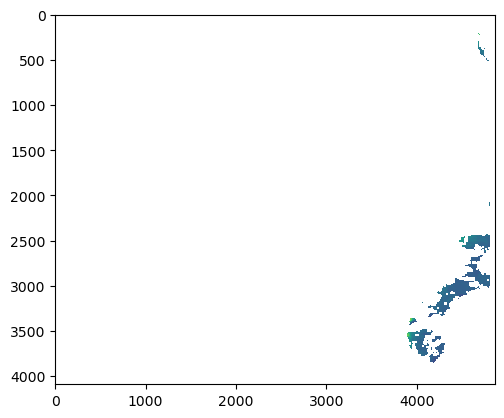

In [26]:
numOI = 1
print(ids[numOI])
fp = f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Sentinel-3_OLCI/S3B/2024/{ids[numOI]}'
satellite = 'Sentinel-3_OLCI/S3B'
ds = makeDataset(fp, satellite)
plt.imshow(ds['Rrs_560'])

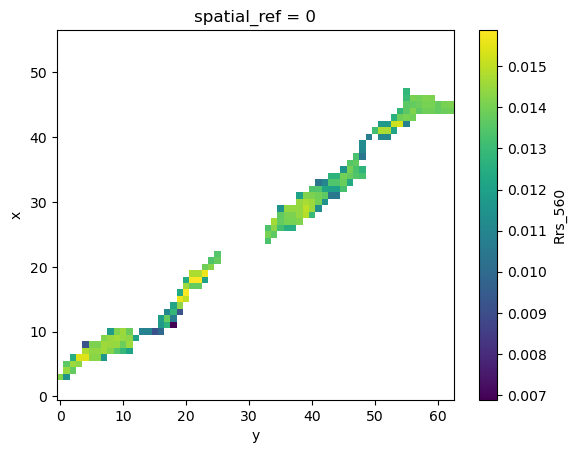

In [34]:
my_lat, my_lon = 39.612375795272236, -76.13272967200766
num = 0.075
max_lat, min_lat = my_lat + num, my_lat - num
max_lon, min_lon = my_lon + num, my_lon - num
mask_lon = (ds.longitude >= min_lon) & (ds.longitude <= max_lon)
mask_lat = (ds.latitude >= min_lat) & (ds.latitude <= max_lat)
dsCrop = ds.where(mask_lon & mask_lat, drop=True)
dsCrop['Rrs_560'].plot()

### B. Compare with corresponding Aeronet Spectra
##### 1. Load in spectra, Concatenate data into 1 file, give time

In [15]:
# Combine MODIS or VIIRS into 1 bulk file
import pandas as pd
import os
satNames = ['OLCIS3A_L2_EFR_OC','OLCIS3B_L2_EFR_OC','MODISA_L2_OC', 'VIIRSN_L2_OC']
mon = 'marglint'
for satName in satNames:
    # Define the directory containing the CSV files, and output loc
    input_directory = f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/{mon}2025_rerun_matchups/{satName}'
    output_file = f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/{mon}2025_rerun_matchups/bulk_Aero_{satName}.csv'
    # Get list of all csv in directory
    csv_files = [os.path.join(input_directory, file) for file in os.listdir(input_directory) if file.endswith('.csv')]
    # Open the output file in write mode
    with open(output_file, 'w') as fout:
        # Initialize a flag to indicate the first file
        is_first_file = True
        # Iterate through the CSV files
        for csv_file in csv_files:
            # Read the CSV file in chunks
            chunks = pd.read_csv(csv_file, chunksize=100000)  # Adjust chunksize as needed
            for chunk in chunks:
                # Write the header only for the first file
                if is_first_file:
                    chunk.to_csv(fout, index=False)
                    is_first_file = False
                else:
                    chunk.to_csv(fout, index=False, header=False)

In [16]:
#Combine S3A and S3B
input_1 = f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/{mon}2025_rerun_matchups/bulk_Aero_OLCIS3A_L2_EFR_OC.csv'
input_2 = f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/{mon}2025_rerun_matchups/bulk_Aero_OLCIS3B_L2_EFR_OC.csv'
output = f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/{mon}2025_rerun_matchups/bulk_Aero_OLCI_combined.csv'
df1 = pd.read_csv(input_1)
df2 = pd.read_csv(input_2)

# Concatenate the DataFrames
combined_df = pd.concat([df1, df2])

# Save the combined DataFrame to a new CSV file
combined_df.to_csv(output, index=False)
combined_df.head()

,Unnamed: 0,Rrs_400,Rrs_412,Rrs_443,Rrs_490,Rrs_510,Rrs_560,Rrs_620,Rrs_665,Rrs_674,Rrs_681,Rrs_709,fn,date,percentValids(flagged/unflagged)
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S3A_OLCI_EFRNT.20210101T152649.L2.OC.nc,01:01:2021,"['0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/..."
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S3A_OLCI_EFRNT.20210102T150038.L2.OC.nc,02:01:2021,"['0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/..."
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S3A_OLCI_EFRNT.20210104T154916.L2.OC.nc,04:01:2021,"['0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/..."
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S3A_OLCI_EFRNT.20210105T152305.L2.OC.nc,05:01:2021,"['0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/..."
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S3A_OLCI_EFRNT.20210106T145655.L2.OC.nc,06:01:2021,"['0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/..."


In [17]:
#Assign datetime (est) to the bulk file
import pandas as pd
from datetime import datetime, timedelta
satNames  = ['OLCI_combined','MODISA_L2_OC', 'VIIRSN_L2_OC']
for satName in satNames:
    print(satName)
    #Read the CSV file
    df = pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/{mon}2025_rerun_matchups/bulk_Aero_{satName}.csv')
    df['datetime'] = pd.to_datetime(df['date'], format='%d:%m:%Y')
    # extract string based on contents
    def extract_string(row):
        if 'OLCI' in satName: return str(row['fn'])[24:30]
        else: return str(row['fn'])[20:26]  # Extract substring for other cases
    
    #create time as a string
    df['time_str'] = df.apply(lambda row: extract_string(row), axis=1)
    
    #combine columns for datetime
    df['datetime_utc'] = pd.to_datetime(df['datetime'].astype('string') + ' ' + df['time_str'], format='%Y-%m-%d %H%M%S')
    
    #UTC -> EST
    def convert_to_est(datetime_utc):
        # Convert datetime from UTC to EST by subtracting 4 hours
        datetime_est = datetime_utc
        return datetime_est
    
    #datetime EST column
    df['datetime_est'] = df['datetime_utc'].apply(convert_to_est)
    
    #save df
    df.to_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/{mon}2025_rerun_matchups/bulk_Aero_{satName}_with_datetime.csv', index=False)
    df.head()

OLCI_combined
MODISA_L2_OC
VIIRSN_L2_OC


#### Update (jan2025) to split aeronet file by ins num

In [18]:
#Calculate rrs from aeronet 
#Load in packages
import os
import numpy as np
import math
import pandas as pd
import scipy.io as sp
import warnings
warnings.filterwarnings("ignore")

# Load in aeronet file
#JupyterLinks/nobackup/Insitu/Aeronet/aeronet_CB_2021_2024_15_jul2024.csv
df_aero = pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Insitu/Aeronet/2021_V3_L15.csv')
print(f' original length: {len(df_aero)}')
years =  [2022, 2023, 2024, 2025]
for yearTemp in years:
    print(f'\nrunning {yearTemp}')
    temp = pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Insitu/Aeronet/{yearTemp}_V3_L15.csv')
    print(f'{yearTemp} df: {len(temp)}')
    df_aero = pd.concat([df_aero, temp], axis=0)
    print(f'current df: {len(df_aero)}')
    print(f'{yearTemp} appended\n----\n')

aeroWvls = [400, 412, 443, 490, 510, 532, 560, 620, 667, 681, 709, 779, 865, 870, 1020] #These are the wavelengths of Aeronet

print(f"---- Aeronet File ----\n  (1) Processing level: [{(df_aero['Data_Quality_Level'][0])}]\n  (2) # Samples: [{len(df_aero)}]\n  (3) Time Range (dd-mm-yyyy): [{(df_aero['Date(dd-mm-yyyy)'][0])} -- {(df_aero['Date(dd-mm-yyyy)'][-1:])}]\n  (4) Wavelengths: {aeroWvls}\n---------------------- ")
#Set constants: Instrument Number, Day of the year, day factor, ecc

print(f' original length: {len(df_aero)}')
#Do one for each unique ins num
bulkAeroRrsDf = pd.DataFrame(columns = ['rrs_400', 'rrs_412', 'rrs_443', 'rrs_490', 'rrs_510', 'rrs_532',
       'rrs_560', 'rrs_620', 'rrs_667', 'Lwn_IOP[681nm]', 'Lwn_IOP[709nm]',
       'rrs_779', 'date', 'time'])

for insNum in df_aero['AERONET_Instrument_Number'].unique():
    try:
        print(f' Ins Num: {insNum}')
        df_aeroCrop = df_aero[df_aero['AERONET_Instrument_Number'] == insNum]
        print(f'cropped length: {len(df_aeroCrop)}')
        #insNum = df_aero.loc[df_aero.index.min()]['AERONET_Instrument_Number']
        dayFactor = 360 / 365.256364
        ecc = 0.01672
        insNum = str(insNum)[0:4]
    
        #Get spectrally convolved f0's from matlab file
        mat_contents = sp.loadmat('/panfs/ccds02/nobackup/people/slsmit34/Scripts/2023_2024/f0_convolved_AERONET.mat')
        bands = mat_contents['f0']['nominalBands'][0][0][0]
        f0s = mat_contents['f0'][f'i{insNum}'][0][0][0] * 100 #Multiply by scaling factor for correct units
        f0_unconvolved = pd.DataFrame(data={'f0s': f0s[:]}, index=bands[:]).T
        f0_unconvolved.head()
        #Enter the desired Lwn category. Here, I use Lwn_IOP for coastal areas (case 2 waters BDRF corrected)
        lwnType = 'Lwn_IOP'
        # Create new df with relevant info
        df_lwn = df_aeroCrop[['Day_of_Year', f'{lwnType}[400nm]', f'{lwnType}[412nm]', f'{lwnType}[443nm]', f'{lwnType}[490nm]', f'{lwnType}[510nm]',f'{lwnType}[532nm]',f'{lwnType}[560nm]', f'{lwnType}[620nm]', f'{lwnType}[667nm]'
                         , f'{lwnType}[681nm]', f'{lwnType}[709nm]', f'{lwnType}[779nm]']]
        df_aeroCrop['Date(dd-mm-yyyy)'] = pd.to_datetime(df_aeroCrop['Date(dd-mm-yyyy)'], format='%d:%m:%Y') #Include year
        df_lwn['date'] = df_aeroCrop['Date(dd-mm-yyyy)']
        df_lwn['Year'] = df_aeroCrop['Date(dd-mm-yyyy)'].dt.year
        def map_dop(year): #Get day of Perihelion (DoP)
            if year == 2021: return 2
            elif year == 2024: return 3
            elif year in [2023, 2022]:return 4
        df_lwn['DoP'] = df_lwn['Year'].apply(map_dop) # Create new col for DoP
        df_lwn['dES'] = 1 - ecc * df_lwn.apply(lambda row: math.cos(dayFactor * (row['Day_of_Year'] - row['DoP'])), axis=1) # calculate dES
        df_lwn.head()
        aero_rrs = pd.DataFrame()
        cols1, cols2 = [], []
        for col in df_lwn.columns:
            for col2 in f0_unconvolved.columns:
                #print(f' col: ...{col[8:-3]}.. col2: ...{col2}')
                try:
                    cols1.append(col)
                    cols2.append(col2)
                    if (col[8:-3]) == str(col2): 
                        print(f' col: ...{col[8:-3]}.. col2: ...{col2}')
                        aero_rrs[col] = df_lwn[col].values / (f0_unconvolved[col2].values * df_lwn['dES']) #final calculation for Rrs
                except:
                    pass;
        column_mapping = {
            'Lwn_IOP[400nm]': 'rrs_400',
            'Lwn_IOP[412nm]': 'rrs_412',
            'Lwn_IOP[443nm]': 'rrs_443',
            'Lwn_IOP[490nm]': 'rrs_490',
            'Lwn_IOP[510nm]': 'rrs_510',
            'Lwn_IOP[532nm]': 'rrs_532',
            'Lwn_IOP[560nm]': 'rrs_560',
            'Lwn_IOP[620nm]': 'rrs_620',
            'Lwn_IOP[667nm]': 'rrs_667',
            'Lwn_IOP[779nm]': 'rrs_779'}
        aero_rrs = aero_rrs.rename(columns=column_mapping)
        aero_rrs['date'] = df_aeroCrop['Date(dd-mm-yyyy)']
        aero_rrs['time'] = df_aeroCrop['Time(hh:mm:ss)']
        aero_rrs['time'] = pd.to_datetime(aero_rrs['time'])
        print(len(aero_rrs))
        #Concatenate to bulk df
        bulkAeroRrsDf = pd.concat([bulkAeroRrsDf, aero_rrs])
    
    except:
        print(f'{insNum} failed')
aero_rrs = bulkAeroRrsDf
print(f'total length: {len(aero_rrs)}')
aero_rrs[1:10]

 original length: 10

running 2022
2022 df: 3126
current df: 3136
2022 appended
----


running 2023
2023 df: 5297
current df: 8433
2023 appended
----


running 2024
2024 df: 5453
current df: 13886
2024 appended
----


running 2025
2025 df: 674
current df: 14560
2025 appended
----

---- Aeronet File ----
  (1) Processing level: [0    lev15
0    lev15
0    lev15
0    lev15
0    lev15
Name: Data_Quality_Level, dtype: object]
  (2) # Samples: [14560]
  (3) Time Range (dd-mm-yyyy): [0    07:10:2021
0    16:02:2022
0    01:01:2023
0    02:01:2024
0    01:01:2025
Name: Date(dd-mm-yyyy), dtype: object -- 673    04:03:2025
Name: Date(dd-mm-yyyy), dtype: object]
  (4) Wavelengths: [400, 412, 443, 490, 510, 532, 560, 620, 667, 681, 709, 779, 865, 870, 1020]
---------------------- 
 original length: 14560
 Ins Num: 1017.0
cropped length: 9207
 col: ...400.. col2: ...400
 col: ...412.. col2: ...412
 col: ...443.. col2: ...443
 col: ...490.. col2: ...490
 col: ...510.. col2: ...510
 col: ...532.. co

,rrs_400,rrs_412,rrs_443,rrs_490,rrs_510,rrs_532,rrs_560,rrs_620,rrs_667,Lwn_IOP[681nm],Lwn_IOP[709nm],rrs_779,date,time
1,0.000646,0.000489,0.001032,0.001432,0.002045,NaN,0.003765,0.002275,0.002376,NaN,NaN,0.000614,2021-10-16,2025-03-11 14:10:02
2,0.001619,0.002077,0.003108,0.004663,0.006208,NaN,0.009860,0.007967,0.006231,NaN,NaN,0.002361,2021-10-17,2025-03-11 15:26:04
3,0.001844,0.001865,0.002899,0.005127,0.006159,NaN,0.009134,0.008200,0.006481,NaN,NaN,0.002356,2021-10-18,2025-03-11 14:10:55
4,0.000557,0.000755,0.001328,0.002317,0.003049,NaN,0.005125,0.003339,0.002669,NaN,NaN,0.001149,2021-10-20,2025-03-11 14:08:36
5,0.000530,0.000724,0.001101,0.002266,0.002863,NaN,0.004860,0.003357,0.002376,NaN,NaN,0.000595,2021-10-20,2025-03-11 15:24:59
6,0.002026,0.002493,0.004554,0.007903,0.009782,NaN,0.014481,0.012922,0.011060,NaN,NaN,0.002203,2021-11-09,2025-03-11 14:26:49
7,0.001195,0.001243,0.002738,0.004840,0.006079,NaN,0.009829,0.007690,0.005821,NaN,NaN,0.001071,2021-11-10,2025-03-11 14:24:16
8,0.000436,0.000897,0.001698,0.003804,0.004363,NaN,0.007498,0.005520,0.003922,NaN,NaN,0.001027,2021-11-17,2025-03-11 14:24:50
9,0.001525,0.001884,0.002607,0.004498,0.005307,NaN,0.008000,0.006390,0.004582,NaN,NaN,0.001681,2021-11-17,2025-03-11 15:08:24


In [116]:
# label each satellite point with avg aeronet data
aerowvl = 443
satName = 'OLCI_combined'#['OLCI_combined', 'MODISA_L2_OC', 'VIIRSN_L2_OC']
mon = 'marglint'

df = pd.read_csv(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/{mon}2025_rerun_matchups/bulk_Aero_{satName}_with_datetime.csv')

#Logic to remove by min threshold for OLCI
if satName == 'OLCI_combined':
    df['numValid'] = df['percentValids(flagged/unflagged)'].str[2:3]
    df['numValid'] = pd.to_numeric(df['numValid'])
    df = df[df['numValid']>0]
    print(f"removed 0's: {len(df)}")
    df = df[df['numValid']>=5]
    print(f"removed 5's: {len(df)}")
#df = df_old 
print('Aeronet wavelengths: [400, 412, 443, 490, 510, 532, 560, 620, 667, 681, 709, 779, 865, 870, 1020]\n---')
wvlDict = {'VIIRSN_L2_OC': ['410', '443', '486', '551', '671'],
           'MODISA_L2_OC': ['412', '443', '488', '555', '667'],
           'OLCI_S3A': ['400', '412', '443', '490', '510', '560', '620', '665', '674', '681', '709'],
           'OLCI_S3B': ['400', '412', '443', '490', '510', '560', '620', '665', '674', '681', '709'],
           'OLCI_combined': ['400', '412', '443', '490', '510', '560', '620', '665', '674', '681', '709']}
satWvls = []
for number in wvlDict[satName]: satWvls.append(int(number))
wavelength = min(satWvls, key = lambda x: abs(x - aerowvl))
print(f'aeronet: {aerowvl}\n{satName}: {wavelength}')
#recreate datetime column to match
aero_rrs['datetime_est'] = pd.to_datetime(aero_rrs['date'].astype('str') + ' ' + aero_rrs['time'].dt.time.astype('str'))
df_wv = df[[f'Rrs_{wavelength}', 'date', 'datetime_est']]
aero_wv = aero_rrs[[f'rrs_{aerowvl}', 'date',  'datetime_est']]

removed 0's: 491
removed 5's: 416
Aeronet wavelengths: [400, 412, 443, 490, 510, 532, 560, 620, 667, 681, 709, 779, 865, 870, 1020]
---
aeronet: 443
OLCI_combined: 443


In [117]:
# alternative method to Aeronet matchups (less code)
import pandas as pd
import numpy as np
closest_entries = []
for index, row in df_wv.iterrows():
    # Extract datetime_est from df_wv
    print(f'{index}: ' + str({row['datetime_est']}))
    datetime_est_wv = pd.to_datetime(row['datetime_est'])
    print(f'df_wv {satName}: {datetime_est_wv}')
    # Calculate the time difference between each entry in aero_wv and datetime_est_wv
    aero_wv['time_diff'] = (aero_wv['datetime_est'] - datetime_est_wv).abs()
    # Filter to keep only entries within 60 minutes
    tdelta = 60
    aero_wv_within_90min = aero_wv[aero_wv['time_diff'] <= pd.Timedelta(f'{tdelta} minutes')]
    
    if not aero_wv_within_90min.empty:
        closest_row = aero_wv_within_90min.loc[aero_wv_within_90min['time_diff'].idxmin()]
        print(closest_row['datetime_est'])
        closest_entry = closest_row[f'rrs_{aerowvl}']
    else:
        print('nan')
        closest_entry = np.nan
    closest_entries.append(closest_entry)
    print(f' ')
df_wv['closest_aero'] = closest_entries
df_wv = df_wv.dropna(subset=[f'Rrs_{wavelength}', 'closest_aero'])
len(df_wv)

7: {'2021-01-10 14:53:11'}
df_wv OLCI_combined: 2021-01-10 14:53:11
nan
 
8: {'2021-01-12 15:41:49'}
df_wv OLCI_combined: 2021-01-12 15:41:49
nan
 
13: {'2021-01-20 15:34:21'}
df_wv OLCI_combined: 2021-01-20 15:34:21
nan
 
15: {'2021-01-24 15:30:37'}
df_wv OLCI_combined: 2021-01-24 15:30:37
nan
 
22: {'2021-02-04 15:45:35'}
df_wv OLCI_combined: 2021-02-04 15:45:35
nan
 
23: {'2021-02-05 15:19:25'}
df_wv OLCI_combined: 2021-02-05 15:19:25
nan
 
25: {'2021-02-08 15:41:51'}
df_wv OLCI_combined: 2021-02-08 15:41:51
nan
 
31: {'2021-02-17 15:08:11'}
df_wv OLCI_combined: 2021-02-17 15:08:11
nan
 
32: {'2021-02-20 15:30:37'}
df_wv OLCI_combined: 2021-02-20 15:30:37
nan
 
33: {'2021-02-21 15:04:26'}
df_wv OLCI_combined: 2021-02-21 15:04:26
nan
 
34: {'2021-02-24 15:26:52'}
df_wv OLCI_combined: 2021-02-24 15:26:52
nan
 
35: {'2021-02-25 15:00:41'}
df_wv OLCI_combined: 2021-02-25 15:00:41
nan
 
42: {'2021-03-08 15:15:37'}
df_wv OLCI_combined: 2021-03-08 15:15:37
nan
 
49: {'2021-03-20 15:04:23'}

253

In [118]:
df_wv['date'].nunique()

233

OLCI_combined 443nm
-------------
n = 253
RMSE: 0.0016777204286216984
------------------
  n = 253
  Bias: 0.00108
  MAE: 0.00127
  RMSE: 0.00168
  R: 0.77561
-----------------
RMSE as percent: 0.6215910441055434
np RMSPE: 0.0016777204286216984


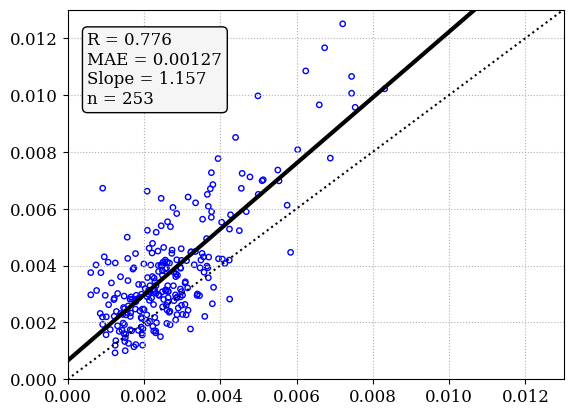

In [119]:
# Produce formatted plot
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import numpy as np
from scipy.stats import linregress
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
myColor = 'b'
myLim = 0.013 #.013 #.025

plt.grid(True, linestyle=':')
plt.grid(alpha=1, zorder = 0)
# Scatter plot with face color gainsboro and size 10
plt.scatter(df_wv['closest_aero'], df_wv[f'Rrs_{wavelength}'], facecolor = 'none', edgecolor = myColor, s=15, alpha = 1)
#plt.gca().set_facecolor('gainsboro')
# White grid with transparency


# Title with font size 12
#plt.title(f"Aero-OC {aerowvl}nm: {satName} {wavelength}nm\nTdelta = {tdelta} min, n = {len(df_wv)}", fontsize=12)

# X and Y labels with font size 12
#plt.xlabel(f'Aeronet-OC {aerowvl}nm Rrs', fontsize=12)
#plt.ylabel(f'{satName} {wavelength}nm Rrs', fontsize=12)

# Calc lin regress
lin_sal = linregress(df_wv['closest_aero'], df_wv[f'Rrs_{wavelength}'])
slope = lin_sal.slope
intercept = lin_sal.intercept
rval = lin_sal.rvalue

# formatting for plot
#plt.xlim(0, 0.008)
#plt.ylim(0, 0.008)

# Calculate MAE
y_true = df_wv['closest_aero']  # aeronet values
predictions = df_wv[f'Rrs_{wavelength}']  # satellite values

def mae(y_true, predictions):
    #y_true, predictions = np.array(y_true), np.array(predictions) #Original
    #return np.mean(np.abs(y_true - predictions)) #Original
    oneOverN = 1/len(predictions)# From Concha 2021
    return(oneOverN * (np.sum(np.abs(predictions - y_true)))) # From Concha 2021
    
def bias(y_true, predictions):
    #return np.mean(predictions - y_true) #Original
    oneOverN = 1/len(predictions) # From Concha 2021
    return(oneOverN * np.sum(predictions - y_true)) # From Concha 2021
    
def rmse(y_true, predictions):
    #return np.sqrt(np.mean((predictions - y_true) ** 2))
    oneOverN = 1/len(predictions) # From Concha 2021
    return(np.sqrt(oneOverN * np.sum((predictions - y_true)**2)))
    
def stderror(y_true, predictions):
    return np.std(predictions, ddof=1) / np.sqrt(np.size(predictions))

def rmse_regression(y_true, predictions):
    from sklearn.metrics import mean_squared_error
    
    # Calculate MSE
    mse = mean_squared_error(y_true, predictions)
    
    # Calculate RMSE
    rmse = np.sqrt(mse)
    
    print("RMSE:", rmse)
    return(rmse)

mean_error = mae(y_true, predictions)
bias_value = bias(y_true, predictions)
std_error_mean = stderror(y_true, predictions)
print(f'{satName} {aerowvl}nm\n-------------')
rmse_value = rmse(y_true, predictions)
#print(f"RMSE: {rmse_value:.5f}")
print(f'n = {len(predictions)}')
rmspe_value = rmse_regression(y_true, predictions)

# Plot regression lines
plt.axline((0, intercept), slope=slope, c='black', alpha=1, zorder=2, lw = 3)
plt.axline((0, 0), slope=1, c='black', alpha=1, zorder=2, linestyle=':')

# Print regression information
mean = np.mean(y_true)
#print(f'R = {rval}\nMAE={mean_error}\nstdErr mean = {std_error_mean}\nmean = {mean}')
print(f'------------------')
print(f'  n = {len(predictions)}')
print(f"  Bias: {bias_value:.5f}")
print(f"  MAE: {mean_error:.5f}")
print(f"  RMSE: {rmse_value:.5f}")
print(f"  R: {rval:.5f}")
print(f"-----------------")

print(f'RMSE as percent: {rmse_value/mean}')
print(f'np RMSPE: {rmspe_value}')

# Formatting the plot..
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
textstr = f'R = {round(rval, 3)}\nMAE = {round(mean_error, 5)}\nSlope = {round(slope, 3)}\nn = {len(predictions)}'
props = dict(boxstyle='round', facecolor='whitesmoke', edgecolor='black')
plt.text(0.04, .94, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='left', bbox=props)
plt.xlim(0,myLim)
plt.ylim(0,myLim)
# Show the plot
plt.savefig(f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/{mon}2025_rerun_matchups/{satName}_{aerowvl}nm_{tdelta}min.png')
plt.show()

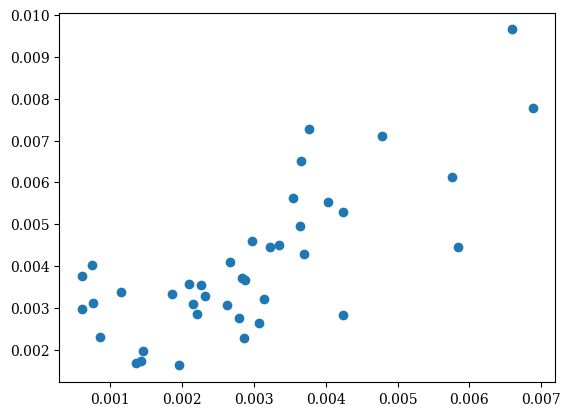

In [128]:
#boolean mask for non-unique dates
non_unique_mask = df_wv['date'].duplicated(keep=False)

# Apply mask to crop the DataFrame
df_wv_cropped = df_wv[non_unique_mask]
df_wv_cropped_sorted = df_wv_cropped.sort_values(by='datetime_est')
plt.scatter(df_wv_cropped_sorted['closest_aero'], df_wv_cropped_sorted['Rrs_443'])